# RNN Baseline Implementation

In [2]:
!pip install einops

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim

from einops import rearrange  

### Data Loading and Preprocessing

In [66]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]["filename"]
        self.all_images_index = self.csv[:]["ind"]
        self.all_labels = np.array(self.csv.drop(["filename", "ind"], axis=1))
        self.train_ratio = int(0.6 * len(self.csv))
        self.valid_ratio = int(0.2 * len(self.csv))
        self.test_ratio =  len(self.csv) - self.train_ratio - self.valid_ratio
 
        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[: self.train_ratio])
            self.labels = list(self.all_labels[: self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            )
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[self.train_ratio : self.train_ratio+self.valid_ratio])
            self.labels = list(self.all_labels[self.train_ratio : self.train_ratio+self.valid_ratio])
#             # define the validation transforms
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            )
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            print(f"Number of validation images: {self.test_ratio}")
            self.image_names = list(self.all_image_names[-self.test_ratio:])
            self.labels = list(self.all_labels[-self.test_ratio:])
            # define the test transforms
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                ]
            )

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        image = cv2.imread(f"/content/drive/MyDrive/NNDL/data/raw_images/{self.image_names[index]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]

        return {
            "image": torch.tensor(image, dtype=torch.float32),
            "label": torch.tensor(targets, dtype=torch.float32),
        }

In [67]:
# Used in creating data loaders as well as in train loops
BATCH_SIZE = 1

In [68]:
train_csv_sample = pd.read_csv("/content/drive/MyDrive/NNDL/data/processed/train.csv")
# train dataset
# train_csv_sample = train_csv.sample(frac=1, random_state=1)
# train_csv_sample = train_csv

train_data = ImageDataset(train_csv_sample[:2000], train=True, test=False)
# validation dataset
valid_data = ImageDataset(train_csv_sample[:2000], train=False, test=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)



Number of training images: 1199
Number of validation images: 399


### Model

In [69]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()

        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        self.layer1 = nn.RNN(self.n_inputs, self.n_neurons)
        self.layer2 = nn.RNN(self.n_neurons, self.n_neurons)
        self.layer3 = nn.Linear(self.n_neurons, self.n_outputs)

    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return torch.zeros(1, self.batch_size, self.n_neurons)

    def forward(self, X, h_init):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2)

        # self.batch_size = X.size(1)
        # self.hidden = self.init_hidden()

        g_seq , g_final = self.layer1(X , h_init)
        h_seq, h_final = self.layer2(g_seq, g_final)
        score_seq = self.layer3(h_final)

        return score_seq.view(-1, self.n_outputs), h_final #out.view(-1, self.n_outputs)  # batch_size X n_output

In [70]:
N_STEPS = 144
N_INPUTS = 768
N_NEURONS = 150
N_OUTPUTS = 6

N_EPHOCS = 20

LR = 0.001
PATCH_SIZE = 16

In [71]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

### Training

In [72]:
def get_accuracy(logit, target, batch_size):
    """ Obtain accuracy for training round """
    # FIXME: The below does not account for batch_size > 1 - change the definition accordingly
    pred = (logit > 0.5).float()
    acc = ((pred == target).sum().item() / target.shape[1]) * 100
    return acc

def get_error(outputs ,labels, batch_size):
    lab = torch.where(outputs>=0.5,1,0)
    indicator = torch.where(lab!=labels, 1, 0)
    non_matches=torch.sum(indicator, axis=0)
    error = non_matches.float()/batch_size
    return error

In [ ]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    
    train_running_loss = 0.0
    train_acc = 0.0
    train_err = 0.0 

    model.train()

    # if epoch >= 4:
    #     LR = LR / 1.1
     
    # optimizer = torch.optim.SGD(model.parameters(), lr=LR)

    h = torch.zeros(1, BATCH_SIZE, model.n_neurons)
    h = h.to(device)

    # TRAINING ROUND
    for i, data in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # reset hidden states
        model.hidden = model.init_hidden()

        # get the inputs
        inputs, labels = data.values()
        img_patches = rearrange(
            inputs.view(BATCH_SIZE, 3, 144, 256),
            "b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)",
            patch_x=PATCH_SIZE,
            patch_y=PATCH_SIZE,
        )

        img_patches = img_patches.to(device)
        labels = labels.to(device)

        h = h.detach()
        h = h.requires_grad_()

        # forward + backward + optimize
        outputs, h = model(img_patches, h)

        # print(outputs)
        # outputs = model(img_patches)
        outputs = torch.sigmoid(outputs).to(device)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs.detach(), labels, BATCH_SIZE)
        train_err += get_error(outputs.detach(), labels, BATCH_SIZE)


    model.eval()
    print(
        "Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f"
        % (epoch, train_running_loss / i, train_acc / i)
    )
    print("Train Error: ", (train_err / i))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  0 | Loss: 0.4157 | Train Accuracy: 81.66
Train Error:  tensor([0.1878, 0.0668, 0.3289, 0.2078, 0.2671, 0.0467], device='cuda:0')
Epoch:  1 | Loss: 0.3167 | Train Accuracy: 86.41
Train Error:  tensor([0.1427, 0.0576, 0.2212, 0.1694, 0.1987, 0.0309], device='cuda:0')
Epoch:  2 | Loss: 0.3207 | Train Accuracy: 85.53
Train Error:  tensor([0.1452, 0.0534, 0.2588, 0.1661, 0.2137, 0.0359], device='cuda:0')
Epoch:  3 | Loss: 0.3792 | Train Accuracy: 83.03
Train Error:  tensor([0.1786, 0.0659, 0.2755, 0.2154, 0.2362, 0.0518], device='cuda:0')
Epoch:  4 | Loss: 0.4278 | Train Accuracy: 80.98
Train Error:  tensor([0.1870, 0.0693, 0.3122, 0.2262, 0.2938, 0.0576], device='cuda:0')
Epoch:  5 | Loss: 0.4036 | Train Accuracy: 81.40
Train Error:  tensor([0.1811, 0.0710, 0.3280, 0.2254, 0.2596, 0.0559], device='cuda:0')
Epoch:  6 | Loss: 0.3591 | Train Accuracy: 83.81
Train Error:  tensor([0.1603, 0.0668, 0.2738, 0.1920, 0.2371, 0.0467], device='cuda:0')
Epoch:  7 | Loss: 0.3245 | Train Accuracy

actors:  ['chandler' 'joey' 'monica' 'phoebe' 'rachel' 'ross']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


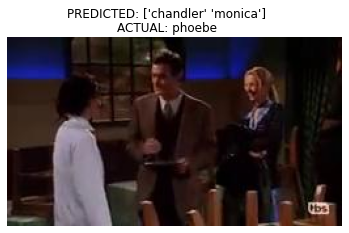

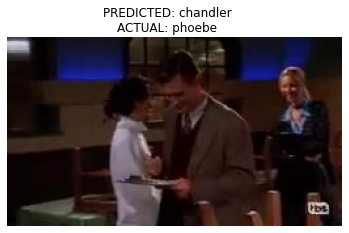

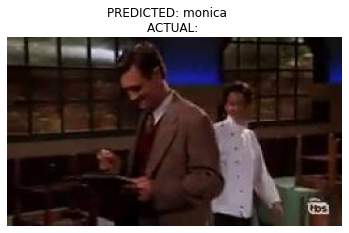

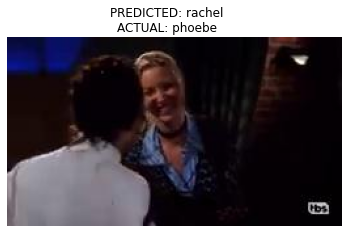

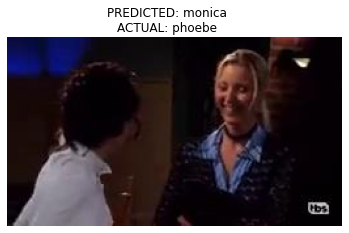

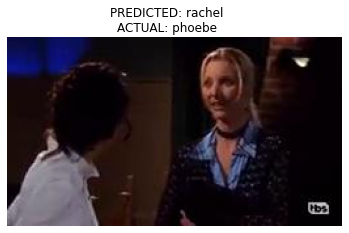

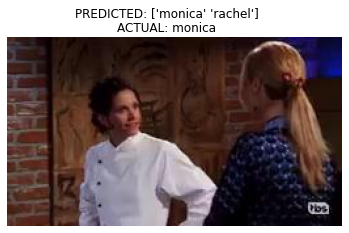

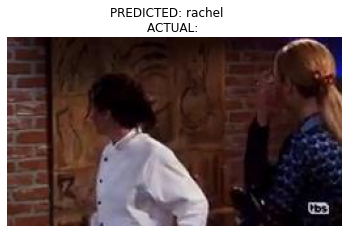

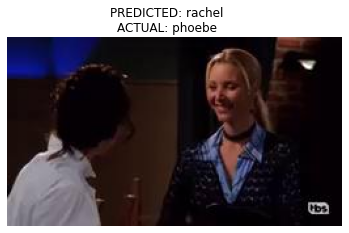

Test Error:  0.0


In [54]:
model.eval()
running_error = 0.0
running_acc = 0.0

actors = train_csv.columns.values[2:]
print('actors: ', actors)

for counter, data in enumerate(valid_loader):

    h = torch.zeros(1, BATCH_SIZE, model.n_neurons)
    h = h.to(device)

    inputs, labels = data.values()
    target_indices = [i for i in range(len(labels[0])) if labels[0][i] == 1]
    
    img_patches = rearrange(
        inputs.view(BATCH_SIZE, 3, 144, 256),
        "b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)",
        patch_x=PATCH_SIZE,
        patch_y=PATCH_SIZE,
    )

    img_patches = img_patches.to(device)
    labels = labels.to(device)

    h = h.detach()
    h = h.requires_grad_()

    # forward + backward + optimize
    outputs, h = model(img_patches, h)

    # print(outputs)
    # outputs = model(img_patches)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    

    lab = torch.where(outputs>=0.5,1,0)[0]
    pred = torch.where(lab==1)

    # running_error += get_error(outputs, labels, 1)
    # running_acc += get_accuracy(outputs, labels, 1)
    
    string_predicted = ""
    string_actual = ""
    for i in range(len(pred)):
        string_predicted += f"{actors[pred[i]]}    "
    for i in range(len(target_indices)):
        string_actual += f"{actors[target_indices[i]]}    "
        
    if 10< counter < 20:
        # print(image)
        image = inputs.squeeze(0)
        image = image.detach().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"PREDICTED: {string_predicted}\nACTUAL: {string_actual}")
        plt.show()
    
test_error = running_error / counter
print(f"Test Error: ", test_error)

### Testing

In [ ]:
test_acc = 0.0
test_err = 0.0

for i, data in enumerate(valid_loader, 0):
    inputs, labels = data.values()
    img_patches = rearrange(
        inputs.view(BATCH_SIZE, 3, 144, 256),
        "b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)",
        patch_x=PATCH_SIZE,
        patch_y=PATCH_SIZE,
    )

    outputs = model(img_patches)
    outputs = torch.sigmoid(outputs)

    test_acc += get_accuracy(outputs.detach(), labels, BATCH_SIZE)
    test_err += get_error(outputs, labels, BATCH_SIZE)

print("Test Accuracy: %.2f" % (test_acc / i))
print('Test Error:', (test_err / i))